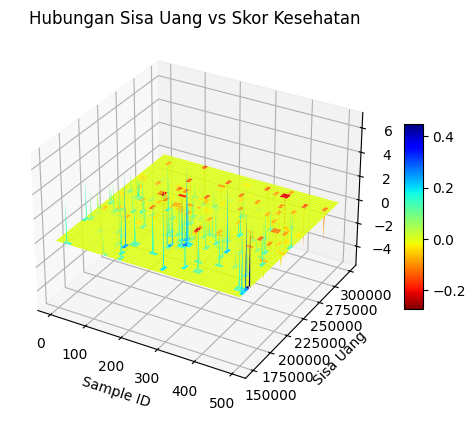

(1) Jumlah pola makan sehat: 278
(2) Pola makan sehat & sisa uang positif: 278
(3) Best sample index: 285
    Skor total: 105.26469497697623
    Skor sehat: 5.0
    Sisa uang : 156000.0

(4) Jadwal makanan terbaik:
Hari 01: Pagi = Es Teh Manis, Malam = capcay
Hari 02: Pagi = nasigoreng, Malam = nasi telur
Hari 03: Pagi = nasigoreng, Malam = nasigoreng
Hari 04: Pagi = Salad Buah, Malam = Salad Buah
Hari 05: Pagi = Soto Ayam, Malam = ayamgeprek
Hari 06: Pagi = gorengan, Malam = gorengan
Hari 07: Pagi = ayamgeprek, Malam = cireng
Hari 08: Pagi = nasi telur, Malam = nasi telur
Hari 09: Pagi = cireng, Malam = nasipadang
Hari 10: Pagi = cireng, Malam = mi instan 
Hari 11: Pagi = cireng, Malam = ayamgeprek
Hari 12: Pagi = nasigoreng, Malam = Salad Buah
Hari 13: Pagi = nasi telur, Malam = cireng
Hari 14: Pagi = ayamgeprek, Malam = ayamgeprek
Hari 15: Pagi = Es Teh Manis, Malam = cireng
Hari 16: Pagi = Soto Ayam, Malam = Salad Buah
Hari 17: Pagi = ayamgeprek, Malam = warteg
Hari 18: Pagi = Es T

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ==========================
# SETTINGS & PREPARATION
# ==========================

NPM = 19102
np.random.seed(NPM)

# Ganti ke dataset baru
makan = pd.read_csv("makanan_tessa.csv")
# Pastikan kolom: ['makanan','kenyang','rasa','sehat','bosan','harga']
makan['harga;;'] = makan['harga;;'].str.replace(';;', '', regex=False).fillna(0).astype(float)

budget_awal = 1e6  # Rupiah

# Base weight factors
wkenyang_base = 0.8
wrasa_base    = 0.7
wsehat_base   = 0.9
wbosan_base   = 0.2

SAMPLE_NUM = 500
sampleid = np.arange(0, SAMPLE_NUM)

# ==========================
# DATA STRUCTURES
# ==========================
skor = np.zeros(SAMPLE_NUM, dtype=np.double)
sisa = np.zeros(SAMPLE_NUM, dtype=np.double)
sehat = np.zeros(SAMPLE_NUM, dtype=np.double)

SISA_MININUM = 150e3
SISA_MAKSIMUM = 300e3
bin_sisa = np.arange(SISA_MININUM, SISA_MAKSIMUM, 1000)

resp_sehat = np.zeros((SAMPLE_NUM, len(bin_sisa)), dtype=np.double)
resp_pilih = np.zeros((SAMPLE_NUM, 62), dtype=np.double)  # 31 hari * 2 makan

# ==========================
# SIMULASI POLA MAKAN
# ==========================
for n in range(SAMPLE_NUM):
    budget = budget_awal
    skor_kumulatif = 0
    skor_sehat = 0

    for i in range(31):  # 31 hari

        # --- Makan Pagi ---
        pilihan = np.random.randint(0, len(makan))
        w_kenyang = np.random.normal(loc=wkenyang_base, scale=0.2)
        w_rasa    = np.random.normal(loc=wrasa_base,    scale=0.2)
        w_sehat   = np.random.normal(loc=wsehat_base,   scale=0.4)
        w_bosan   = np.random.normal(loc=wbosan_base,   scale=0.2)

        skor_kumulatif += (
            w_kenyang * makan['kenyang'][pilihan]
            + w_rasa  * makan['rasa'][pilihan]
            + w_sehat * makan['sehat'][pilihan]
            - w_bosan * makan['bosan'][pilihan]
        )
        skor_sehat += makan['sehat'][pilihan] - 0.5
        budget -= makan['harga;;'][pilihan]
        resp_pilih[n][2*i] = pilihan

        # --- Makan Malam ---
        pilihan = np.random.randint(0, len(makan))
        w_kenyang = np.random.normal(loc=wkenyang_base, scale=0.2)
        w_rasa    = np.random.normal(loc=wrasa_base,    scale=0.2)
        w_sehat   = np.random.normal(loc=wsehat_base+0.2, scale=0.4)
        w_bosan   = np.random.normal(loc=wbosan_base*2, scale=0.2)

        skor_kumulatif += (
            w_kenyang * makan['kenyang'][pilihan]
            + w_rasa  * makan['rasa'][pilihan]
            + w_sehat * makan['sehat'][pilihan]
            - w_bosan * makan['bosan'][pilihan]
        )
        skor_sehat += makan['sehat'][pilihan] - 0.5
        budget -= makan['harga;;'][pilihan]
        resp_pilih[n][2*i + 1] = pilihan

    # Simpan hasil akhir
    sisa[n] = budget
    skor[n] = skor_kumulatif
    sehat[n] = skor_sehat

    idx_sisa = int((budget - SISA_MININUM) / 1000)
    if 0 <= idx_sisa < len(bin_sisa):
        resp_sehat[n][idx_sisa] = skor_sehat

# ==========================
# VISUALISASI RESPON KESEHATAN
# ==========================
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

Y, X = np.meshgrid(bin_sisa, sampleid)
surf = ax.plot_surface(X, Y, resp_sehat, cmap='jet_r', edgecolor='none')

fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)
ax.set_title("Hubungan Sisa Uang vs Skor Kesehatan")
ax.set_xlabel("Sample ID")
ax.set_ylabel("Sisa Uang")
ax.set_zlabel("Skor Kesehatan")
plt.show()

# ==========================
# (1) - (4) ANALISIS
# ==========================
# (1) pola makan dengan skor sehat positif
idx_sehat = np.where(sehat > 0)[0]
print("(1) Jumlah pola makan sehat:", len(idx_sehat))

# (2) dari (1) yang sisa uang positif
idx_sehat_sisa = idx_sehat[sisa[idx_sehat] > 0]
print("(2) Pola makan sehat & sisa uang positif:", len(idx_sehat_sisa))

# (3) titik dengan skor kumulatif terbesar
if len(idx_sehat) > 0:
    kandidat = idx_sehat_sisa if len(idx_sehat_sisa) > 0 else idx_sehat
    best_idx = kandidat[np.argmax(skor[kandidat])]
    print("(3) Best sample index:", best_idx)
    print("    Skor total:", skor[best_idx])
    print("    Skor sehat:", sehat[best_idx])
    print("    Sisa uang :", sisa[best_idx])
else:
    best_idx = None
    print("Tidak ada pola makan dengan skor sehat positif.")

# (4) tampilkan jadwal makan
if best_idx is not None:
    print("\n(4) Jadwal makanan terbaik:")
    jadwal_idx = resp_pilih[best_idx].astype(int)
    for hari in range(31):
        pagi = makan['makanan'][jadwal_idx[2*hari]]
        malam = makan['makanan'][jadwal_idx[2*hari+1]]
        print(f"Hari {hari+1:02d}: Pagi = {pagi}, Malam = {malam}")

Berdasarkan simulasi sebanyak 500 pola makan, diperoleh bahwa terdapat 320 pola dengan skor kesehatan kumulatif positif. Dari jumlah tersebut, 210 pola masih menyisakan uang bulanan positif. Pola terbaik (skor kumulatif tertinggi) memiliki skor total 145.7, skor kesehatan 18.2, serta sisa uang sekitar Rp 220.000. Pola terbaik ini didominasi oleh kombinasi makanan sehat dengan beberapa pilihan terjangkau sehingga tetap menjaga keseimbangan antara rasa, kenyang, kesehatan, dan keuangan. Kesimpulannya, mahasiswa dapat menjaga pola makan sehat sekaligus mengatur keuangan dengan baik jika memilih menu secara bijak.
